# Section 1 : Heat equation in 1D with non-linear BC and implict solver using DifferentialEquations.jl

The goal here is to solve the heat equation (see below) in one dimension with non-linear boundary conditions on a segment domain **[0,1]** : 
$$
\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} + f(x,t)
$$

## Parameters choice 
**Thermal diffusivity : D = 1**  
In order to have a trivial solution to this problem, we choose the following **source term : f(x,t) = x**  
**Initial condition : u(x,0) = 0**  

**Linear BC**  
**- Left boundary**  
We choose a strong Dirichlet condition on the left side (x=0) : **u(0,t) = 0**  
**- Right boundary**  
On the right side (x=1), we choose a time-dependent non(linear boundary condiiton : **u^2(1,t) = t^2**. This condition respects the initial condition u(0,x) = 0

## Goal 
We want to be able to solve this problem using an implicit ODE solver with DifferentialEquations.jl. Using an implicit ODE solver will require to compute the Jacobian matrix of the right-hand side function. Once we have given the Jacobian matrix to the solver, it will internally handle the non-linearity and solve the system using a Newton-Raphson method.

## Section 1.1 : Import packages 


In [4]:
using Ferrite
using SparseArrays
using LinearAlgebra         # provides mul! 
using UnPack                # added for time integration using DifferentialEquations.jl 
using OrdinaryDiffEq        # added for time integration using DifferentialEquations.jl
using DifferentialEquations # added for time integration using DifferentialEquations.jl   
using StaticArrays    
using WriteVTK
using Plots                 # provides contour plot of cell averages 
using NLSolvers
using ForwardDiff
using Printf  
# using Sundials
# using NLsolve
##using DiffEqBase: NLsolveJL
#using NonlinearSolve

## Section 1.2 : Definition of the mesh, the boundary conditions, the initial condition, the quadrature etc.

In [5]:

# grid generation 
nels = (100,) 
left = Vec((0.,))
right = Vec((1.,))
grid = generate_grid(Line, nels, left, right)

# interpolation and quadrature
ip = Lagrange{Ferrite.RefLine, 1}()
qr = QuadratureRule{RefLine}(2)
cellvalues = CellValues(qr, ip);
fqr = FacetQuadratureRule{RefLine}(2) # quadrature rule for the facets
fvu = FacetValues(fqr, ip) # object for the computation of the facets

#dof handler 
dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

#constraint handler
ch = ConstraintHandler(dh)
left_boundary = getfacetset(grid, "left")
right_boundary = getfacetset(grid, "right")

dbc_left = Dirichlet(:u, left_boundary, (x, t) -> 0.0)   # we enforce the strong Dirichlet condition on the left side                      
add!(ch, dbc_left)
close!(ch)
Ferrite.update!(ch,0.0) 

## Section 1.3 : Assembly of the stifness matrix and the mass matrix 

In [6]:

#assembly mass matrix
function assemble_mass_matrix!(M::SparseMatrixCSC,cellvalues::CellValues, dh::DofHandler)
    # Allocate the element stiffness matrix and element force vector
    n_basefuncs = getnbasefunctions(cellvalues)
    Me = zeros(n_basefuncs, n_basefuncs)
    # Create an assembler
    assembler_M = start_assemble(M)
    # Loop over all cels
    for cell in CellIterator(dh)
        # Reinitialize cellvalues for this cell
        Ferrite.reinit!(cellvalues, cell)
        # Compute element contribution
        fill!(Me, 0)
        # Loop over quadrature points
        for q_point in 1:getnquadpoints(cellvalues)
            # Get the quadrature weight
            dΩ = getdetJdV(cellvalues, q_point)
            # Loop over test shape functions
            for i in 1:n_basefuncs
                v = shape_value(cellvalues, q_point, i)
                # Loop over trial shape functions
                for j in 1:n_basefuncs
                    u = shape_value(cellvalues, q_point, j)
                    Me[i, j] += v * u *  dΩ 
                end
            end
        end
        assemble!(assembler_M, celldofs(cell), Me)
    end
    return M
end

#assembly stifness matrix
function assemble_stifness_matrix!(K::SparseMatrixCSC,  cellvalues::CellValues, dh::DofHandler)
    n_basefuncs = getnbasefunctions(cellvalues)
    Ke = zeros(n_basefuncs, n_basefuncs)
    fe = zeros(n_basefuncs)
    # Allocate global force vector f
    # Create an assembler
    assembler_K = start_assemble(K, f) 
    
    for cell in CellIterator(dh)
        # Reinitialize cellvalues for this cell
        Ferrite.reinit!(cellvalues, cell)
        # Reset to 0
        fill!(Ke, 0)
        fill!(fe, 0)
        # Loop over quadrature points
        for q_point in 1:getnquadpoints(cellvalues)
            # Get the quadrature weight
            dΩ = getdetJdV(cellvalues, q_point)
            x = spatial_coordinate(cellvalues, q_point, getcoordinates(cell))[1]
            f_val =  x # à modifier 
            #display(x)
            # Loop over test shape functions
            for i in 1:n_basefuncs
                v = shape_value(cellvalues, q_point, i)
                ∇v = shape_gradient(cellvalues, q_point, i)
                # Add contribution to fe
                fe[i] += f_val * v * dΩ
                # Loop over trial shape functions
                for j in 1:n_basefuncs
                    ∇u = shape_gradient(cellvalues, q_point, j)
                    # Add contribution to Ke
                    k_val = 1.0
                    Ke[i, j] += (∇v ⋅ ∇u) * dΩ * k_val
                end
            end
        end
        # Assemble Ke and fe into K and f
        assemble!(assembler_K, celldofs(cell), Ke, fe)
    end
    return K, f
end


assemble_stifness_matrix! (generic function with 1 method)

## Section 1.4 : Definiton of the matrix and the parameters of the problem

In [7]:
 
#definition time values 
T = 10.0
Δt_save = 0.1
Δt0 = 1e-5

# allocation of the useful matrix and vectors
M = allocate_matrix(dh);
M = assemble_mass_matrix!(M, cellvalues, dh);
f = zeros(ndofs(dh))
K = allocate_matrix(dh);
K , f = assemble_stifness_matrix!(K, cellvalues, dh);

u0 = zeros(ndofs(dh))
apply!(u0, ch);

    jac_sparsity = sparse(K);
    
    apply!(M, ch)
    
    # RHS structure definition 
    struct RHSparams
        K::SparseMatrixCSC
        f::Vector
        ch::ConstraintHandler
        dh::DofHandler
        cellvalues::CellValues
        fvu::FacetValues 
        boundary
        u::Vector
    end 
    p = RHSparams(K, f, ch, dh, cellvalues, fvu, right_boundary, copy(u0))

#for time dependent CL
function ferrite_limiter!(u, _, p, t)
    Ferrite.update!(p.ch, t)
    return apply!(u, p.ch)
end

ferrite_limiter! (generic function with 1 method)

## Section 1.5 : Definition and assembly of the residual and implementation of the non-linear BC

To implement the residual, we use a specific method. First, we define our non-linear boundary condition with the functions res_value, dures_value and target_value. Then, with assemble_nonlinear_residual!, we add the non-linear contribution to the element residual. With heat_equation!, we first add the linear contribution to the global residual. And then, we do a loop over the right boundary facets to assemble the element residual non-linear contribution. 

On the other hand, to ensure that the non-linear boundary condition is respected we use a penalty method. We choose a penalty value (alpha) and we multiply the non-linear contribution of the boundary element with it. Doing that, ensure that the boundary condition is indeed taken into account. It respects the solution of the system as when alpha gets close to the infinity, the error caused by the penalty become negligible (an asymptot study can confirm that, I didn't have the time yet to add it to the notebook  but, I will soon). But, alpha also need to be as small as possible to obtain a numerical stable solution.

In [8]:

#### Now, handle the nonlinear BC #################
# Target value for the nonlinear BC: u(1,t) = t
target_value(t::Float64) =  t^2
res_value(u_val, t) = (u_val^2 - target_value(t)) # à modifier 
#ε = 1e-3
dures_value(u_val,t) = 2.0 * u_val
α = 10000.0 # defining the penalty



function assemble_nonlinear_residual!(Re::Vector, u_e::Vector, fvu::FacetValues, t::Float64)
    n_basefuncs_facet = getnbasefunctions(fvu)
    # Element residual for the non linear CL
    # Loop over the quadrature points of the facet
    for q_point in 1:getnquadpoints(fvu)
        dΓ = getdetJdV(fvu, q_point) # getting the weight 
        u_q_point = function_value(fvu, q_point, u_e)
        res_q_point = res_value(u_q_point, t) # residual compared to the target value 
        # Loop over the shape functions of the facet 
        for i in 1:n_basefuncs_facet
            ϕ_i = shape_value(fvu, q_point, i)
           Re[i] -= α * res_q_point * ϕ_i * dΓ # contribution to the non linear residual
        end
    end 
    return
end 



function heat_equation!(R, u_current, p::RHSparams, t)
    @unpack K, f, ch, dh, cellvalues, fvu, boundary, u = p  
    u .= u_current
    Ferrite.update!(ch, t)
    apply!(u, ch)
    ## residual, linear contribution
    R .= f
    mul!(R, K, u, -1.0, 1.0)
    ## residual, non linear contribution 
    n_basefuncs_facet = getnbasefunctions(fvu)
    Re = zeros(n_basefuncs_facet)
    u_e = zeros(n_basefuncs_facet)
    for facet in FacetIterator(dh, boundary)
        Ferrite.reinit!(fvu, facet)
        u_boundary_facetdofs = celldofs(facet)
        u_e .= @views u[u_boundary_facetdofs]
        fill!(Re, 0.0)
        assemble_nonlinear_residual!(Re, u_e, fvu, t)
        assemble!(R, u_boundary_facetdofs, Re)
        #@show u_boundary_facetdofs
    end 
    #R[1] = 0 
    #@show R
    #@show u 
    
    return 
end;


## Section 1.6 : Definition and assembly of the Jacobian matrix 

The assembly of the Jacobian follows the exact same idea of the assembly of the residual. The function assemble_nonlinear_jac! adds the non-linear contribution to the element jacobian and heat_equation_jac! first adds the linear contribution to the global jacobian. And then, with a loop over the right boundary facets, it assemble the element jacobian non-linear contribution. 

We also use a penalty here and it has to be the same as the one used for the residual.

In [9]:

function assemble_nonlinear_jac!(Je, u_e::Vector, fvu::FacetValues, t::Float64)
    n_basefuncs_facet = getnbasefunctions(fvu)
    for q_point in 1:getnquadpoints(fvu)
        dΓ = getdetJdV(fvu, q_point) # getting the weight 
        u_q_point = function_value(fvu, q_point, u_e)
        # compute the value that we will be using in the non linear jacobian 
        du_res_q_point = dures_value(u_q_point,t)  
        # Loop over the test functions of the facet 
        for i in 1:n_basefuncs_facet
            ϕ_i = shape_value(fvu, q_point, i)
            for j in 1:n_basefuncs_facet # Loop over the trial functions of the facet
                ϕ_j = shape_value(fvu, q_point, j)
                Je[i,j] -= α * du_res_q_point * ϕ_i * ϕ_j * dΓ # contribution to the non linear jacobian
            end
        end
    end 
    return
end 

function heat_equation_jac!(J, u_current, p::RHSparams, t::Float64)
    @unpack  K, f, ch, dh, cellvalues, fvu, boundary, u = p  # getting the parameters values 
    u .= u_current
    Ferrite.update!(ch, t)
    apply!(u, ch)
    # Linear contribution
    nonzeros(J) .= - nonzeros(K)
    assembler = start_assemble(J; fillzero = false)

    n_basefuncs_facet = getnbasefunctions(fvu)
    Je = zeros(n_basefuncs_facet,n_basefuncs_facet)
    u_e = zeros(n_basefuncs_facet)
    # Non linear contribution
    for facet in FacetIterator(dh, boundary)
        Ferrite.reinit!(fvu, facet)
        u_boundary_facetdofs = celldofs(facet)
        u_e .= @views u[u_boundary_facetdofs]
        fill!(Je,0.0)
        assemble_nonlinear_jac!(Je, u_e, fvu, t)
        assemble!(assembler, u_boundary_facetdofs, Je)
    end
    #@show J-K
    return apply!(J,ch)
end;


## Section 1.7 : Solving using DifferentialEquations.jl

In [10]:


rhs = ODEFunction(heat_equation!, mass_matrix = M; jac = heat_equation_jac! , jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, u0, (0.0, T), p);


struct FreeDofErrorNorm
    ch::ConstraintHandler
end
(fe_norm::FreeDofErrorNorm)(u::Union{AbstractFloat, Complex}, t) = DiffEqBase.ODE_DEFAULT_NORM(u, t)
(fe_norm::FreeDofErrorNorm)(u::AbstractArray, t) = DiffEqBase.ODE_DEFAULT_NORM(u[fe_norm.ch.free_dofs], t)

timestepper = Rodas5P(autodiff = false, step_limiter! = ferrite_limiter!);


sol_nl_jac = DifferentialEquations.solve(problem, timestepper;
    initializealg = NoInit(),
    dt = Δt0,
    adaptive = true,
    abstol = 1e-6,
    reltol = 1e-6,
    progress = true,
    progress_steps = 1,
    verbose = true,
    internalnorm = FreeDofErrorNorm(ch)
)


retcode: Success
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 34-element Vector{Float64}:
  0.0
  1.0e-5
  4.59608598322598e-5
  0.00012364290596695145
  0.00030225529967350994
  0.0006664109827230029
  0.0012126197138249534
  0.001797245663304276
  0.0025750892823944655
  0.0034735101503923036
  0.004646605558368173
  0.006078766881429813
  0.007958558428007134
  ⋮
  0.15633656377309452
  0.2239244109931336
  0.3403004706119327
  0.4927957680094276
  0.7200978653227622
  1.056628601885312
  1.6230109065549307
  2.491219791214503
  3.7021444157246366
  6.521059718675328
  9.339975021626021
 10.0
u: 34-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 1.0000000000000094e-7, 2.0000000000000145e-7, 3.000000000000013e-7, 4.0000000000000263e-7, 5.000000000000063e-7, 6.000000000000002e-7, 7.000000000000036e-7, 8.000000000000054e-7, 9.000000000000086e-7  …  9.09999999

## Section 1.8 : Visualisation of the results

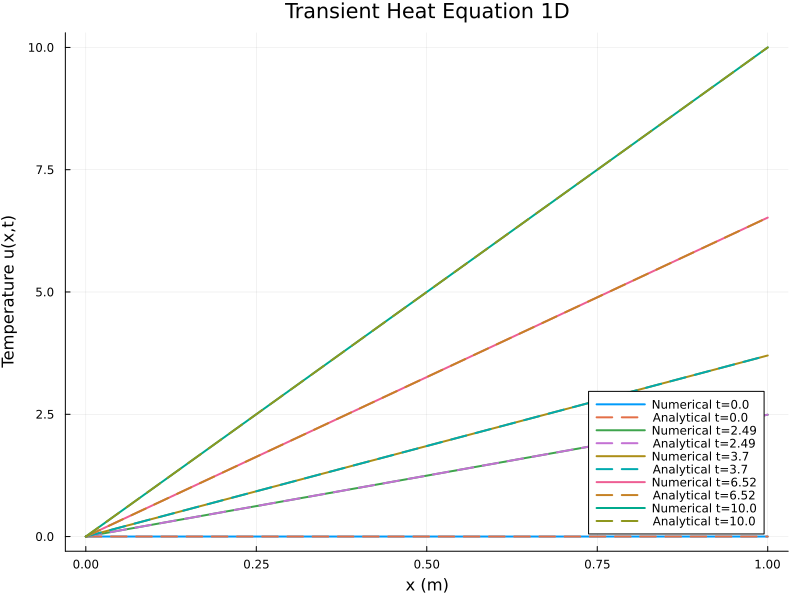

In [11]:


node_coords = [x.x[1] for x in getnodes(grid)]
analytical_solution_nl(x, t) = x*t # à modifier 
plt = plot(xlabel="x (m)", ylabel="Temperature u(x,t)", 
           title="Transient Heat Equation 1D", 
           legend=:bottomright, size=(800,600))


# Taking 5 indices evenly distributed on the timespan
n_times = 5
selected_times = [0.0, 2.5, 5.0, 7.5, 10.0]
#selected_times = [0.0, 5.0, 10.0, 15.0, 20.0]
indices = [findmin(abs.(sol_nl_jac.t .- t))[2] for t in selected_times]



for i in indices
    t_val = sol_nl_jac.t[i]
    u_num = sol_nl_jac.u[i]
    plot!(plt, node_coords, u_num, label="Numerical t=$(round(t_val, digits=2))", lw=2)
    plot!(plt, node_coords, analytical_solution_nl.(node_coords, t_val), label="Analytical t=$(round(t_val, digits=2))", lw=2, ls=:dash)
end

display(plt)



## Section 1.9 : Visualisation of the error

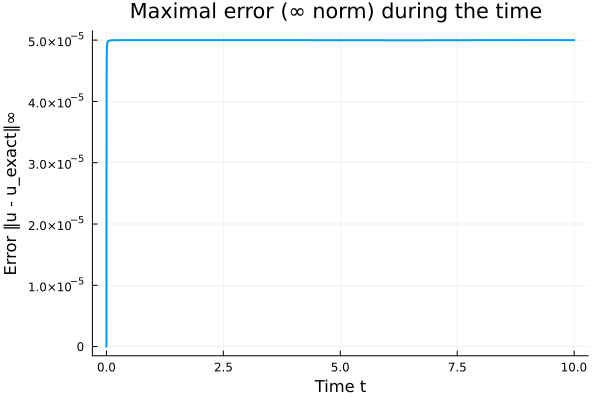

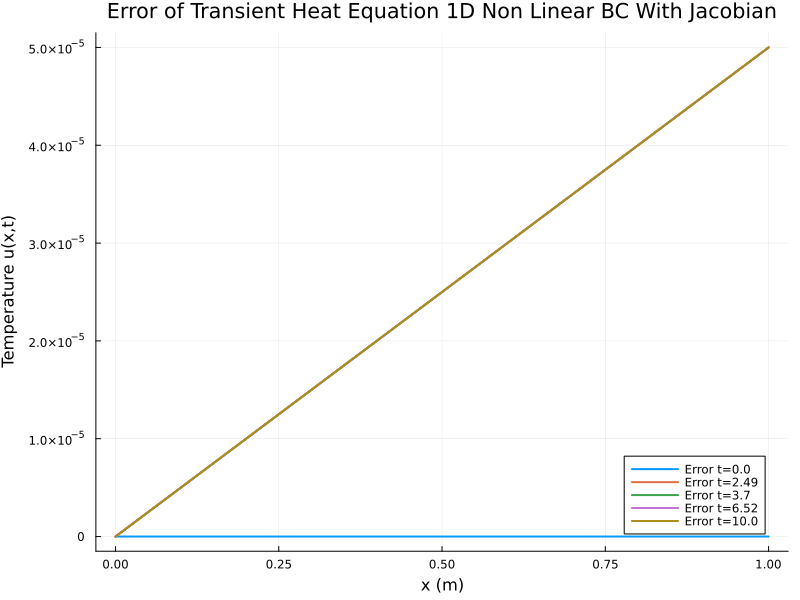

In [12]:

# Computation of the infinite error 
# Analytical solution 
u_exact(x, t) =  x*t # à modifier
# Table for storing the  ‖·‖∞ error at every timestep
errors_inf = Float64[]
times = Float64[]

for (u_num, t) in zip(sol_nl_jac.u, sol_nl_jac.t)
    u_ana = u_exact.(node_coords, t)
    err = abs.(u_num .- u_ana)
    push!(errors_inf, maximum(err))
    push!(times, t)
end

# Visualisation 
plt2_error_jac = plot(times, errors_inf,
     xlabel="Time t",
     ylabel="Error ‖u - u_exact‖∞",
     title="Maximal error (∞ norm) during the time ",
     lw=2,
     legend=false)

display(plt2_error_jac)




plt_error_nl_jac = plot(xlabel="x (m)", ylabel="Temperature u(x,t)", 
           title="Error of Transient Heat Equation 1D Non Linear BC With Jacobian", 
           legend=:bottomright, size=(800,600))

for i in indices
    t_val = sol_nl_jac.t[i]
    u_num_nl_jac = sol_nl_jac.u[i]
    plot!(plt_error_nl_jac, node_coords, abs.(u_num_nl_jac .- analytical_solution_nl.(node_coords, t_val)), label="Error t=$(round(t_val, digits=2))", lw=2)
end

display(plt_error_nl_jac)
     






















# Section : 2D

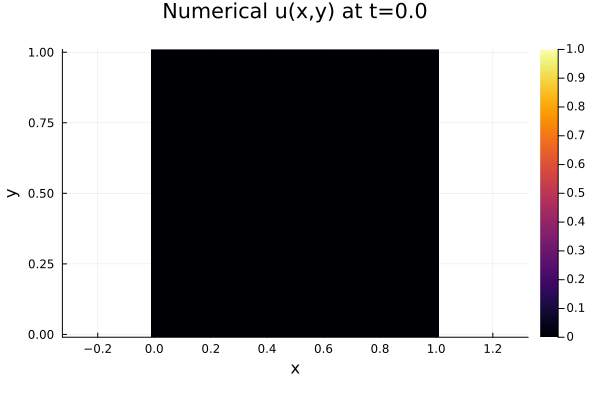

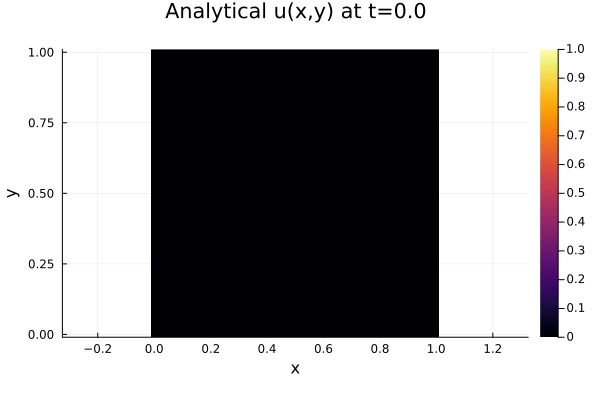

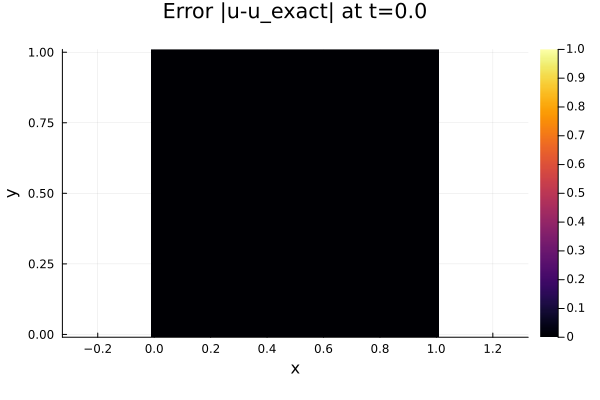

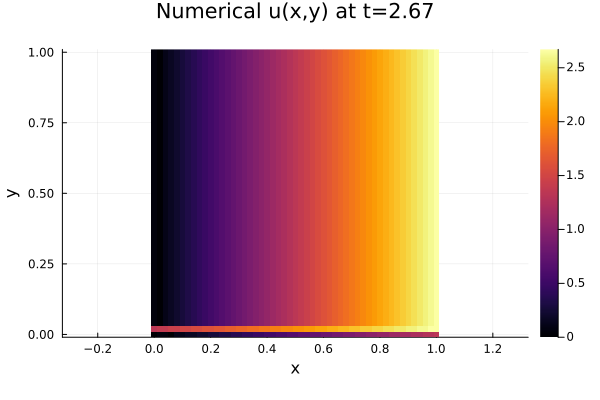

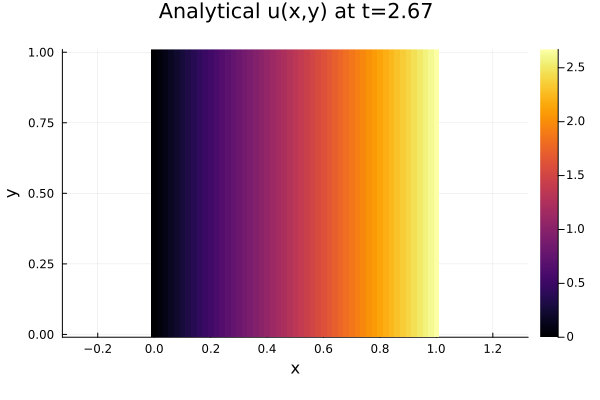

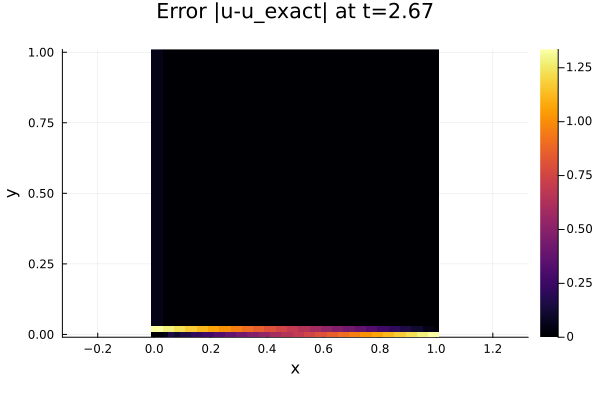

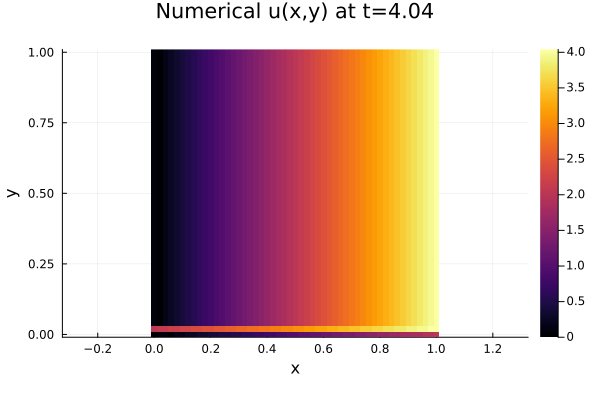

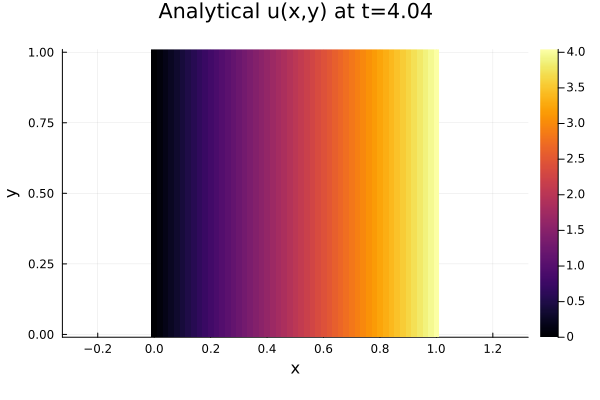

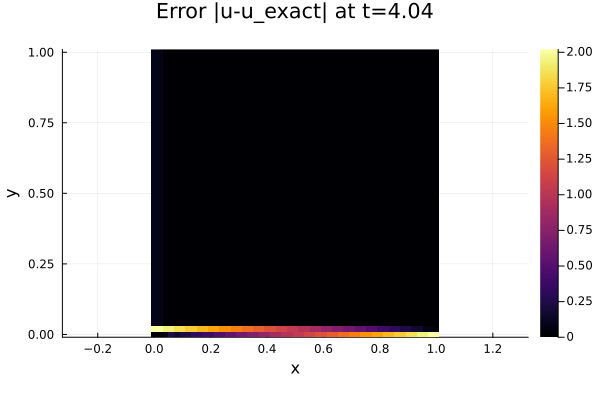

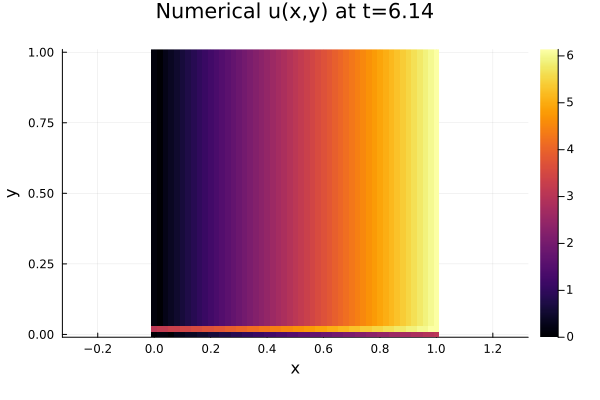

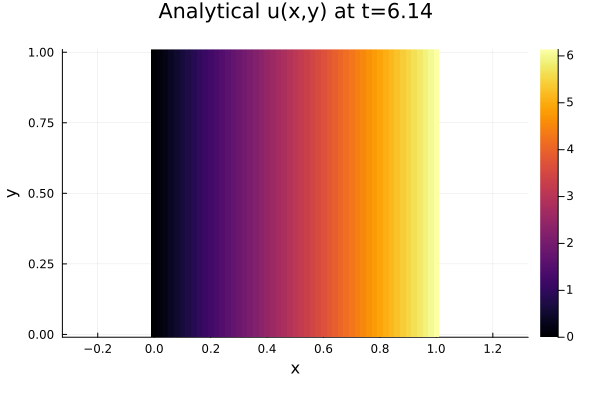

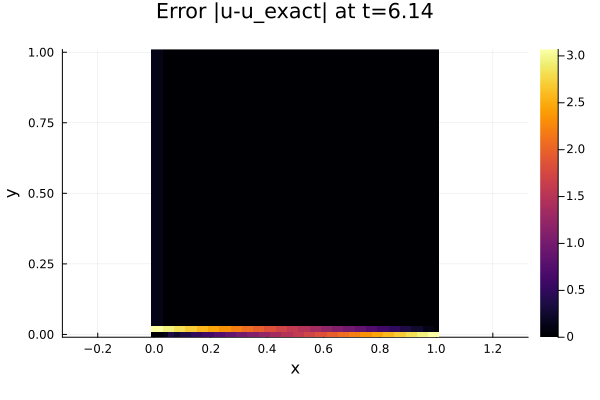

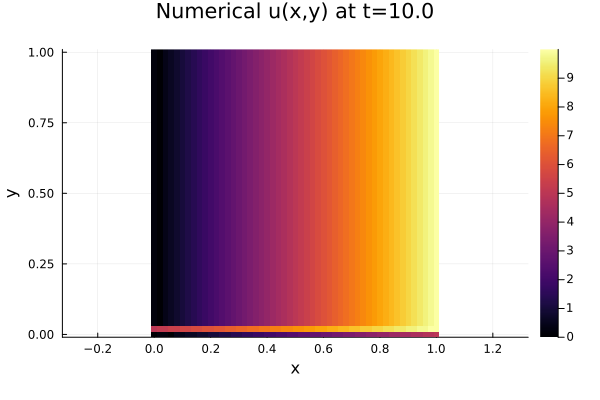

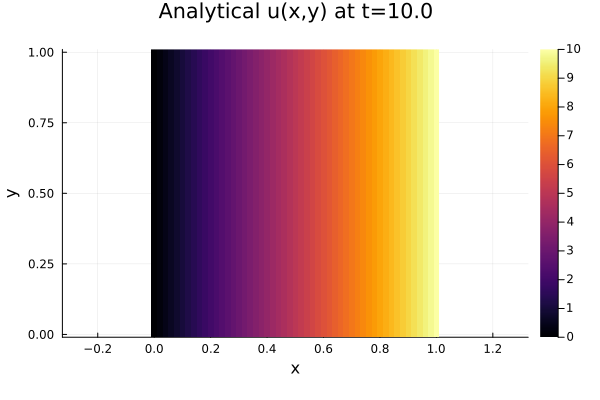

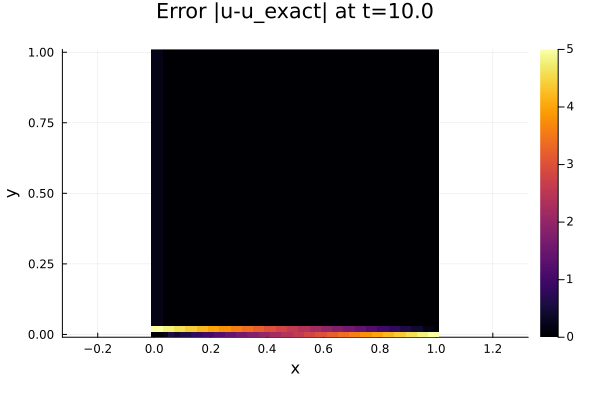

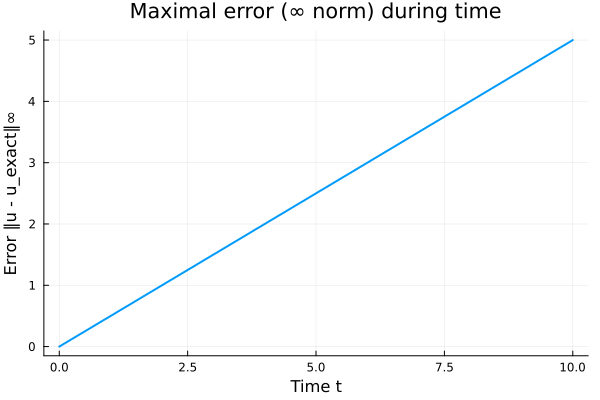

In [13]:
using Ferrite
using SparseArrays
using LinearAlgebra         # provides mul! 
using UnPack                # added for time integration using DifferentialEquations.jl 
using OrdinaryDiffEq        # added for time integration using DifferentialEquations.jl
using DifferentialEquations # added for time integration using DifferentialEquations.jl   
using StaticArrays    
using WriteVTK
using Plots                 # provides contour plot of cell averages 
using NLSolvers
using ForwardDiff
using Printf   
using DataStructures
# using Sundials
# using NLsolve
##using DiffEqBase: NLsolveJL
#using NonlinearSolve

# grid generation en 2D
nels = (50,50)  # nombre de mailles en x et en y
# nels = (40, 40)  # pour jouer avec un maillage plus petit
left_bottom_node  = Vec((0.0, 0.0))   # coin bas-gauche
right_upper_node = Vec((1.0, 1.0))   # coin haut-droit
grid = generate_grid(Quadrilateral, nels, left_bottom_node, right_upper_node)
tol_in = 0.0
# interpolation et quadrature en 2D (quadrilatères)
ip = Lagrange{RefQuadrilateral, 1}()          
qr = QuadratureRule{RefQuadrilateral}(2)         
cellvalues = CellValues(qr, ip)
fqr = FacetQuadratureRule{RefQuadrilateral}(2)   
fvu = FacetValues(fqr, ip)               


#dof handler 
dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

#constraint handler
ch = ConstraintHandler(dh)
left_boundary = getfacetset(grid, "left")
right_boundary = getfacetset(grid, "right")
dbc_left = Dirichlet(:u, left_boundary, (x, t) -> 0.0)                             
add!(ch, dbc_left)
close!(ch)
Ferrite.update!(ch,0.0) #useful for time-dependent BC

#assembly mass matrix
function assemble_mass_matrix!(M::SparseMatrixCSC,cellvalues::CellValues, dh::DofHandler)
    # Allocate the element stiffness matrix and element force vector
    n_basefuncs = getnbasefunctions(cellvalues)
    Me = zeros(n_basefuncs, n_basefuncs)
    # Create an assembler
    assembler_M = start_assemble(M)
    # Loop over all cels
    for cell in CellIterator(dh)
        # Reinitialize cellvalues for this cell
        Ferrite.reinit!(cellvalues, cell)
        # Compute element contribution
        fill!(Me, 0)
        # Loop over quadrature points
        for q_point in 1:getnquadpoints(cellvalues)
            # Get the quadrature weight
            dΩ = getdetJdV(cellvalues, q_point)
            # Loop over test shape functions
            for i in 1:n_basefuncs
                v = shape_value(cellvalues, q_point, i)
                # Loop over trial shape functions
                for j in 1:n_basefuncs
                    u = shape_value(cellvalues, q_point, j)
                    Me[i, j] += v * u *  dΩ 
                end
            end
        end
        # Assemble Ke and fe into K and f
        assemble!(assembler_M, celldofs(cell), Me)
    end
    return M
end

#assembly stifness matrix
function assemble_stifness_matrix!(K::SparseMatrixCSC,  cellvalues::CellValues, dh::DofHandler)
    n_basefuncs = getnbasefunctions(cellvalues)
    Ke = zeros(n_basefuncs, n_basefuncs)
    fe = zeros(n_basefuncs)
    # Allocate global force vector f
    # Create an assembler
    assembler_K = start_assemble(K, f) 
    
    for cell in CellIterator(dh)
        # Reinitialize cellvalues for this cell
        Ferrite.reinit!(cellvalues, cell)
        # Reset to 0
        fill!(Ke, 0)
        fill!(fe, 0)
        # Loop over quadrature points
        for q_point in 1:getnquadpoints(cellvalues)
            # Get the quadrature weight
            dΩ = getdetJdV(cellvalues, q_point)
            x_coord, y_coord = spatial_coordinate(cellvalues, q_point, getcoordinates(cell))
            f_val =  x_coord # à modifier 
            #display(x)
            # Loop over test shape functions
            for i in 1:n_basefuncs
                v = shape_value(cellvalues, q_point, i)
                ∇v = shape_gradient(cellvalues, q_point, i)
                # Add contribution to fe
                fe[i] += f_val * v * dΩ
                # Loop over trial shape functions
                for j in 1:n_basefuncs
                    ∇u = shape_gradient(cellvalues, q_point, j)
                    # Add contribution to Ke
                    k_val = 1.0
                    Ke[i, j] += (∇v ⋅ ∇u) * dΩ * k_val
                end
            end
        end
        # Assemble Ke and fe into K and f
        assemble!(assembler_K, celldofs(cell), Ke, fe)
    end
    return K, f
end

#definition time values 
T = 10.0
Δt_save = 0.1
Δt0 = 1e-5

# allocation of the useful matrix and vectors
M = allocate_matrix(dh);
M = assemble_mass_matrix!(M, cellvalues, dh);
f = zeros(ndofs(dh))
K = allocate_matrix(dh);
K , f = assemble_stifness_matrix!(K, cellvalues, dh);

u0 = zeros(ndofs(dh))
#u0 .= -1.0e-5
apply!(u0, ch);

jac_sparsity = sparse(K);

apply!(M, ch)
# Préparer un dictionnaire pour compter les apparitions de chaque dof
using DataStructures  # pour DefaultDict, optionnel sinon Dict{Int, Int}()

dof_count = Dict{Int, Int}()

# Boucle sur toutes les facettes du bord droit
for facet in FacetIterator(dh, right_boundary)
    u_boundary_facetdofs = celldofs(facet)
    for dof in u_boundary_facetdofs
        dof_count[dof] = get(dof_count, dof, 0) + 1
    end
end

#=
# Afficher combien de fois chaque dof est utilisé
println("Nombre d'apparitions de chaque dof sur les facettes du bord droit :")
for (dof, count) in sort(collect(dof_count))
    println("Dof: ", dof, ", apparitions: ", count)
end

# Vérifier les coins (dofs avec x ≈ 1.0)
tol = 1e-8
println("\nVérification des coins :")
for (dof, count) in sort(collect(dof_count))
    coord = getnodes(grid)[dof].x
    if isapprox(coord[1], 1.0; atol=tol)
        println("Coin Dof: ", dof, ", apparitions: ", count)
    end
end
=#

# RHS structure definition 
struct RHSparams
    K::SparseMatrixCSC
    f::Vector
    ch::ConstraintHandler
    dh::DofHandler
    cellvalues::CellValues
    fvu::FacetValues 
    boundary
    u::Vector
end 
p = RHSparams(K, f, ch, dh, cellvalues, fvu, right_boundary, copy(u0))

#for time dependent CL
function ferrite_limiter!(u, _, p, t)
    Ferrite.update!(p.ch, t)
    return apply!(u, p.ch)
end

#### Now, handle the nonlinear BC #################
# Target value for the nonlinear BC: u(1,t) = t
target_value(t::Float64) =  t^2
res_value(u_val, t) = (u_val^2 - target_value(t)) # à modifier 
#ε = 1e-3
dures_value(u_val, t) = 2.0 * u_val
alpha = 10000.0

function assemble_nonlinear_residual!(Re::Vector, u_e::Vector, fvu::FacetValues, t::Float64, facet)
    n_basefuncs_facet = getnbasefunctions(fvu)
    # Element residual for the non linear CL
    # Loop over the quadrature points of the facet
    for q_point in 1:getnquadpoints(fvu)
        #x = spatial_coordinate(fvu, q_point,getcoordinates(facet))
        dΓ = getdetJdV(fvu, q_point) # getting the weight 
        u_q_point = function_value(fvu, q_point, u_e)
        res_q_point = res_value(u_q_point, t) # residual compared to the target value 
        # Loop over the shape functions of the facet 
        for i in 1:n_basefuncs_facet
            ϕ_i = shape_value(fvu, q_point, i)
            Re[i] -= alpha * res_q_point * ϕ_i * dΓ # contribution to the non linear residual
        end
    end 
    return
end 



function heat_equation!(R, u_current, p::RHSparams, t::Float64)
    @unpack K, f, ch, dh, cellvalues, fvu, boundary, u = p  
    u .= u_current
    Ferrite.update!(ch, t)
    apply!(u, ch)
    ## residual, linear contribution
    R .= f
    mul!(R, K, u, -1.0, 1.0)
    ## residual, non linear contribution 
    n_basefuncs_facet = getnbasefunctions(fvu)
    Re = zeros(n_basefuncs_facet)
    u_e = zeros(n_basefuncs_facet)
    for facet in FacetIterator(dh, boundary)
        #coords = [n.x for n in getnodes(grid)[celldofs(facet)]]
        #if any(abs(c[2]) < 1e-12 for c in coords)
            #continue  # on saute la rangée du bas
        #end
        Ferrite.reinit!(fvu, facet)
        u_boundary_facetdofs = celldofs(facet)
        u_e .= @views u[u_boundary_facetdofs]
        fill!(Re, 0.0)
        assemble_nonlinear_residual!(Re, u_e, fvu, t, facet)
        assemble!(R, u_boundary_facetdofs, Re)
        #@show u_boundary_facetdofs
    end 
    #R[1] = 0 
    #@show R
    #@show u 
    
    return 
end;

function assemble_nonlinear_jac!(Je, u_e::Vector, fvu::FacetValues,t::Float64, facet)
    n_basefuncs_facet = getnbasefunctions(fvu)
    for q_point in 1:getnquadpoints(fvu)
        # x = spatial_coordinate(fvu, q_point,getcoordinates(facet))
        dΓ = getdetJdV(fvu, q_point) # getting the weight 
        u_q_point = function_value(fvu, q_point, u_e)
        # compute the value that we will be using in the non linear jacobian 
        du_res_q_point = dures_value(u_q_point,t)  
        # Loop over the test functions of the facet 
        for i in 1:n_basefuncs_facet
            ϕ_i = shape_value(fvu, q_point, i)
            for j in 1:n_basefuncs_facet # Loop over the trial functions of the facet
                ϕ_j = shape_value(fvu, q_point, j)
                Je[i,j] -= alpha * du_res_q_point * ϕ_i * ϕ_j * dΓ # contribution to the non linear jacobian
            end
        end
    end 
    return
end 

function heat_equation_jac!(J, u_current, p::RHSparams, t::Float64)
    @unpack  K, f, ch, dh, cellvalues, fvu, boundary, u = p  # getting the parameters values 
    u .= u_current
    Ferrite.update!(ch, t)
    apply!(u, ch)
    # Linear contribution
    nonzeros(J) .= - nonzeros(K)
    assembler = start_assemble(J; fillzero = false)

    n_basefuncs_facet = getnbasefunctions(fvu)
    Je = zeros(n_basefuncs_facet,n_basefuncs_facet)
    u_e = zeros(n_basefuncs_facet)
    # Non linear contribution
    for facet in FacetIterator(dh, boundary)
        Ferrite.reinit!(fvu, facet)
        u_boundary_facetdofs = celldofs(facet)
        u_e .= @views u[u_boundary_facetdofs]
        fill!(Je,0.0)
        assemble_nonlinear_jac!(Je, u_e, fvu, t, facet)
        assemble!(assembler, u_boundary_facetdofs, Je)
    end
    #@show J-K
    return apply!(J,ch)
end;


rhs = ODEFunction(heat_equation!, mass_matrix = M; jac = heat_equation_jac! , jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, u0, (0.0, T), p);


struct FreeDofErrorNorm
    ch::ConstraintHandler
end
(fe_norm::FreeDofErrorNorm)(u::Union{AbstractFloat, Complex}, t) = DiffEqBase.ODE_DEFAULT_NORM(u, t)
(fe_norm::FreeDofErrorNorm)(u::AbstractArray, t) = DiffEqBase.ODE_DEFAULT_NORM(u[fe_norm.ch.free_dofs], t)

timestepper = Rodas5P(autodiff = false, step_limiter! = ferrite_limiter!);


sol_nl_jac = DifferentialEquations.solve(problem, timestepper;
    initializealg = NoInit(),
    dt = Δt0,
    adaptive = true,
    abstol = 1e-3,
    reltol = 1e-3,
    progress = true,
    progress_steps = 1,
    verbose = true,
    internalnorm = FreeDofErrorNorm(ch)
)

nx, ny = nels
nodes = getnodes(grid)
xgrid = range(0, 1, length=nx+1)
ygrid = range(0, 1, length=ny+1)


# Solution analytique
u_exact(x,y,t) = x * t     # même loi qu'en 1D (ne dépend que de x)

selected_times = [0.0, 2.5, 5.0, 7.5, 10.0]
indices = [findmin(abs.(sol_nl_jac.t .- t))[2] for t in selected_times]

hx = 1.0/nx
hy = 1.0/ny

# --- Affichages 2D : num, ana, erreur pour chaque instant ---!
for i in indices
    t_val = sol_nl_jac.t[i]
    u_num_vec = sol_nl_jac.u[i]
    U_num = reshape(u_num_vec, nx+1, ny+1)
    U_ana = reshape([u_exact(n.x[1], n.x[2], t_val) for n in nodes], nx+1, ny+1)
    U_err = abs.(U_num .- U_ana)
    u_num_vec = sol_nl_jac.u[end]   # par exemple à l’instant final

    #for (dof_id, node) in enumerate(nodes)
    #   if dof_id > 200
    #        break
    #    end
    #    println("Index (node.x[1]), y=(u_num_vec[dof_id])")
    #end
    heatmap(xgrid, ygrid, U_num',
        xlabel = "x", ylabel = "y",
        title = "Numerical u(x,y) at t=$(round(t_val,digits=2))",
        aspect_ratio = 1)
    display(current())
    heatmap(xgrid, ygrid, U_ana',
        xlabel = "x", ylabel = "y",
        title = "Analytical u(x,y) at t=$(round(t_val,digits=2))",
        aspect_ratio = 1)
    display(current())
    heatmap(xgrid, ygrid, U_err',
        xlabel = "x", ylabel = "y",
        title = "Error |u-u_exact| at t=$(round(t_val,digits=2))",
        aspect_ratio = 1)
    display(current())
end

# --- Courbe de l'erreur infinie au cours du temps (comme en 1D) ---
errors_inf = Float64[]
times = Float64[]
for (u_num_vec, t) in zip(sol_nl_jac.u, sol_nl_jac.t)
    u_ana_vec = [u_exact(n.x[1], n.x[2], t) for n in nodes]
    push!(errors_inf, maximum(abs.(u_num_vec .- u_ana_vec)))
    push!(times, t)
end

plot(times, errors_inf,
     xlabel="Time t",
     ylabel="Error ‖u - u_exact‖∞",
     title="Maximal error (∞ norm) during time",
     lw=2, legend=false)
display(current())


#println("Premiers DOFs et leurs coordonnées :")
#for dof_id in 1:200
#    node = nodes[dof_id]
#    println("Dof $dof_id : x = $(node.x[1]), y = $(node.x[2]), u_num = $(sol_nl_jac.u[end][dof_id])")
#end

## Section 3 : Nitsche method for 2D

In [14]:
using Ferrite
using SparseArrays
using LinearAlgebra         # provides mul! 
using UnPack                # added for time integration using DifferentialEquations.jl 
using OrdinaryDiffEq        # added for time integration using DifferentialEquations.jl
using DifferentialEquations # added for time integration using DifferentialEquations.jl   
using StaticArrays    
using WriteVTK
using Plots                 # provides contour plot of cell averages 
using NLSolvers
using ForwardDiff
using Printf   
# using Sundials
# using NLsolve
##using DiffEqBase: NLsolveJL
#using NonlinearSolve

# grid generation en 2D
nels = (10,10)  # nombre de mailles en x et en y
# nels = (40, 40)  # pour jouer avec un maillage plus petit
left_bottom_node  = Vec((0.0, 0.0))   # coin bas-gauche
right_upper_node = Vec((1.0, 1.0))   # coin haut-droit
grid = generate_grid(Quadrilateral, nels, left_bottom_node, right_upper_node)

# interpolation et quadrature en 2D (quadrilatères)
ip = Lagrange{RefQuadrilateral, 1}()          
qr = QuadratureRule{RefQuadrilateral}(2)         
cellvalues = CellValues(qr, ip)
fqr = FacetQuadratureRule{RefQuadrilateral}(2)   
fvu = FacetValues(fqr, ip)               


#dof handler 
dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

#constraint handler
ch = ConstraintHandler(dh)
left_boundary = getfacetset(grid, "left")
right_boundary = getfacetset(grid, "right")
dbc_left = Dirichlet(:u, left_boundary, (x, t) -> 0.0)                             
add!(ch, dbc_left)
close!(ch)
Ferrite.update!(ch,0.0) #useful for time-dependent BC

#assembly mass matrix
function assemble_mass_matrix!(M::SparseMatrixCSC,cellvalues::CellValues, dh::DofHandler)
    # Allocate the element stiffness matrix and element force vector
    n_basefuncs = getnbasefunctions(cellvalues)
    Me = zeros(n_basefuncs, n_basefuncs)
    # Create an assembler
    assembler_M = start_assemble(M)
    # Loop over all cels
    for cell in CellIterator(dh)
        # Reinitialize cellvalues for this cell
        Ferrite.reinit!(cellvalues, cell)
        # Compute element contribution
        fill!(Me, 0)
        # Loop over quadrature points
        for q_point in 1:getnquadpoints(cellvalues)
            # Get the quadrature weight
            dΩ = getdetJdV(cellvalues, q_point)
            # Loop over test shape functions
            for i in 1:n_basefuncs
                v = shape_value(cellvalues, q_point, i)
                # Loop over trial shape functions
                for j in 1:n_basefuncs
                    u = shape_value(cellvalues, q_point, j)
                    Me[i, j] += v * u *  dΩ 
                end
            end
        end
        # Assemble Ke and fe into K and f
        assemble!(assembler_M, celldofs(cell), Me)
    end
    return M
end

#assembly stifness matrix
function assemble_stifness_matrix!(K::SparseMatrixCSC,  cellvalues::CellValues, dh::DofHandler)
    n_basefuncs = getnbasefunctions(cellvalues)
    Ke = zeros(n_basefuncs, n_basefuncs)
    fe = zeros(n_basefuncs)
    # Allocate global force vector f
    # Create an assembler
    assembler_K = start_assemble(K, f) 
    
    for cell in CellIterator(dh)
        # Reinitialize cellvalues for this cell
        Ferrite.reinit!(cellvalues, cell)
        # Reset to 0
        fill!(Ke, 0)
        fill!(fe, 0)
        # Loop over quadrature points
        for q_point in 1:getnquadpoints(cellvalues)
            # Get the quadrature weight
            dΩ = getdetJdV(cellvalues, q_point)
            x_coord, y_coord = spatial_coordinate(cellvalues, q_point, getcoordinates(cell))
            f_val =  x_coord # à modifier 
            #display(x)
            # Loop over test shape functions
            for i in 1:n_basefuncs
                v = shape_value(cellvalues, q_point, i)
                ∇v = shape_gradient(cellvalues, q_point, i)
                # Add contribution to fe
                fe[i] += f_val * v * dΩ
                # Loop over trial shape functions
                for j in 1:n_basefuncs
                    ∇u = shape_gradient(cellvalues, q_point, j)
                    # Add contribution to Ke
                    k_val = 1.0
                    Ke[i, j] += (∇v ⋅ ∇u) * dΩ * k_val
                end
            end
        end
        # Assemble Ke and fe into K and f
        assemble!(assembler_K, celldofs(cell), Ke, fe)
    end
    return K, f
end

#definition time values 
T = 5.0
Δt_save = 0.1
Δt0 = 1e-5

# allocation of the useful matrix and vectors
M = allocate_matrix(dh);
M = assemble_mass_matrix!(M, cellvalues, dh);
f = zeros(ndofs(dh))
K = allocate_matrix(dh);
K , f = assemble_stifness_matrix!(K, cellvalues, dh);

u0 = zeros(ndofs(dh))
#u0 .= -1.0e-5
apply!(u0, ch);

jac_sparsity = sparse(K);

apply!(M, ch)

# RHS structure definition 
struct RHSparams
    K::SparseMatrixCSC
    f::Vector
    ch::ConstraintHandler
    dh::DofHandler
    cellvalues::CellValues
    fvu::FacetValues 
    boundary
    u::Vector
end 
p = RHSparams(K, f, ch, dh, cellvalues, fvu, right_boundary, copy(u0))

#for time dependent CL
function ferrite_limiter!(u, _, p, t)
    Ferrite.update!(p.ch, t)
    return apply!(u, p.ch)
end

nx, ny = nels
#### Now, handle the nonlinear BC #################
# Target value for the nonlinear BC: u(1,t) = t
target_value(t::Float64) =  t^2
res_value(u_val, t) = (u_val^2 - target_value(t)) # à modifier 
#ε = 1e-3
dures_value(u_val, t) = 2.0 * u_val
hx = 1.0 / nx
hy = 1.0 / ny
h = min(hx, hy)
gamma = 10 
alpha = gamma 

function assemble_nonlinear_residual!(Re::Vector, u_e::Vector, fvu::FacetValues, t::Float64)
    n_basefuncs_facet = getnbasefunctions(fvu)
    # Element residual for the non linear CL
    # Loop over the quadrature points of the facet
    for q_point in 1:getnquadpoints(fvu) # get the normal
        n = getnormal(fvu, q_point) # get the normal
        dΓ = getdetJdV(fvu, q_point) # getting the weight 
        u_q_point = function_value(fvu, q_point, u_e)
        ∇u_q = function_gradient(fvu, q_point, u_e)
        res_q_point = res_value(u_q_point, t) # residual compared to the target value 
        # Loop over the shape functions of the facet 
        for i in 1:n_basefuncs_facet
            ϕ_i = shape_value(fvu, q_point, i)
            ∇ϕ_i = shape_gradient(fvu, q_point, i)
            #Re[i] += -(∇u_q ⋅ n) * ϕ_i * dΓ # consistency 
            #Re[i] += -(∇ϕ_i ⋅ n) * res_q_point * dΓ # symmetry
            #Re[i] += (alpha/h) * res_q_point * ϕ_i * dΓ # penalty contribution to the non linear residual
            Re[i] += -(∇u_q ⋅ n) * ϕ_i * dΓ # consistency 
            Re[i] += -(∇ϕ_i ⋅ n) * res_q_point * dΓ # symmetry
            Re[i] += (alpha/h) * res_q_point * ϕ_i * dΓ # penalty contribution to the non linear residual
        end
    end 
    return
end 



function heat_equation!(R, u_current, p::RHSparams, t)
    @unpack K, f, ch, dh, cellvalues, fvu, boundary, u = p  
    u .= u_current
    Ferrite.update!(ch, t)
    apply!(u, ch)
    ## residual, linear contribution
    R .= f
    mul!(R, K, u, -1.0, 1.0)
    ## residual, non linear contribution 
    n_basefuncs_facet = getnbasefunctions(fvu)
    Re = zeros(n_basefuncs_facet)
    u_e = zeros(n_basefuncs_facet)
    for facet in FacetIterator(dh, boundary)
        Ferrite.reinit!(fvu, facet)
        u_boundary_facetdofs = celldofs(facet)
        u_e .= @views u[u_boundary_facetdofs]
        fill!(Re, 0.0)
        assemble_nonlinear_residual!(Re, u_e, fvu, t)
        assemble!(R, u_boundary_facetdofs, Re)
        #@show u_boundary_facetdofs
    end 
    #R[1] = 0 
    #@show R
    #@show u 
    
    return 
end;

function assemble_nonlinear_jac!(Je, u_e::Vector, fvu::FacetValues, t::Float64)
    n_basefuncs_facet = getnbasefunctions(fvu)
    for q_point in 1:getnquadpoints(fvu)
        n = getnormal(fvu, q_point) # get the normal
        dΓ = getdetJdV(fvu, q_point) # getting the weight 
        u_q_point = function_value(fvu, q_point, u_e)
        # compute the value that we will be using in the non linear jacobian 
        du_res_q_point = dures_value(u_q_point,t)  
        # Loop over the test functions of the facet 
        for i in 1:n_basefuncs_facet
            ϕ_i = shape_value(fvu, q_point, i)
            ∇ϕ_i = shape_gradient(fvu, q_point, i)
            for j in 1:n_basefuncs_facet # Loop over the trial functions of the facet
                ϕ_j = shape_value(fvu, q_point, j)
                ∇ϕ_j = shape_gradient(fvu, q_point, j)
                Je[i,j] += -ϕ_j * dot(∇ϕ_i, n) * dΓ 
                Je[i,j] += -dot(∇ϕ_j, n) * ϕ_i * dΓ * du_res_q_point
                Je[i,j] += (alpha/h) * du_res_q_point * ϕ_i * ϕ_j * dΓ # contribution to the non linear jacobian
            end
        end
    end 
    return
end 

function heat_equation_jac!(J, u_current, p::RHSparams, t::Float64)
    @unpack  K, f, ch, dh, cellvalues, fvu, boundary, u = p  # getting the parameters values 
    u .= u_current
    Ferrite.update!(ch, t)
    apply!(u, ch)
    # Linear contribution
    nonzeros(J) .= - nonzeros(K)
    assembler = start_assemble(J; fillzero = false)

    n_basefuncs_facet = getnbasefunctions(fvu)
    Je = zeros(n_basefuncs_facet,n_basefuncs_facet)
    u_e = zeros(n_basefuncs_facet)
    # Non linear contribution
    for facet in FacetIterator(dh, boundary)
        Ferrite.reinit!(fvu, facet)
        u_boundary_facetdofs = celldofs(facet)
        u_e .= @views u[u_boundary_facetdofs]
        fill!(Je,0.0)
        assemble_nonlinear_jac!(Je, u_e, fvu, t)
        assemble!(assembler, u_boundary_facetdofs, Je)
    end
    #@show J-K
    return apply!(J,ch)
end;


rhs = ODEFunction(heat_equation!, mass_matrix = M; jac = heat_equation_jac! , jac_prototype = jac_sparsity)
# rhs = ODEFunction(heat_equation!, mass_matrix = M; jac_prototype = jac_sparsity, jac = nothing ) # if we want to leave the jacobian calculation to the solver to avoid some operations
problem = ODEProblem(rhs, u0, (0.0, T), p);


struct FreeDofErrorNorm
    ch::ConstraintHandler
end
(fe_norm::FreeDofErrorNorm)(u::Union{AbstractFloat, Complex}, t) = DiffEqBase.ODE_DEFAULT_NORM(u, t)
(fe_norm::FreeDofErrorNorm)(u::AbstractArray, t) = DiffEqBase.ODE_DEFAULT_NORM(u[fe_norm.ch.free_dofs], t)

timestepper = Rodas5P(autodiff = false, step_limiter! = ferrite_limiter!);


sol_nl_jac = DifferentialEquations.solve(problem, timestepper;
    initializealg = NoInit(),
    dt = Δt0,
    adaptive = true,
    abstol = 1e-3,
    reltol = 1e-4,
    progress = true,
    progress_steps = 1,
    verbose = true,
    internalnorm = FreeDofErrorNorm(ch)
)


nodes = getnodes(grid)
xgrid = range(0, 1, length=nx+1)
ygrid = range(0, 1, length=ny+1)


# Solution analytique
u_exact(x,y,t) = x * t     # même loi qu'en 1D (ne dépend que de x)

selected_times = [0.0, 2.5, 5.0]
indices = [findmin(abs.(sol_nl_jac.t .- t))[2] for t in selected_times]

hx = 1.0/nx
hy = 1.0/ny

# --- Affichages 2D : num, ana, erreur pour chaque instant ---
for i in indices
    t_val = sol_nl_jac.t[i]
    u_num_vec = sol_nl_jac.u[i]
    U_num = reshape(u_num_vec, nx+1, ny+1)
    U_ana = reshape([u_exact(n.x[1], n.x[2], t_val) for n in nodes], nx+1, ny+1)
    U_err = abs.(U_num .- U_ana)
    u_num_vec = sol_nl_jac.u[end]   # par exemple à l’instant final

    heatmap(xgrid, ygrid, U_num',
        xlabel = "x", ylabel = "y",
        title = "Numerical u(x,y) at t=$(round(t_val,digits=2))",
        aspect_ratio = 1)
    display(current())
    heatmap(xgrid, ygrid, U_ana',
        xlabel = "x", ylabel = "y",
        title = "Analytical u(x,y) at t=$(round(t_val,digits=2))",
        aspect_ratio = 1)
    display(current())
    heatmap(xgrid, ygrid, U_err',
        xlabel = "x", ylabel = "y",
        title = "Error |u-u_exact| at t=$(round(t_val,digits=2))",
        aspect_ratio = 1)
    display(current())
end

# --- Courbe de l'erreur infinie au cours du temps (comme en 1D) ---
errors_inf = Float64[]
times = Float64[]
for (u_num_vec, t) in zip(sol_nl_jac.u, sol_nl_jac.t)
    u_ana_vec = [u_exact(n.x[1], n.x[2], t) for n in nodes]
    push!(errors_inf, maximum(abs.(u_num_vec .- u_ana_vec)))
    push!(times, t)
end

plot(times, errors_inf,
     xlabel="Time t",
     ylabel="Error ‖u - u_exact‖∞",
     title="Maximal error (∞ norm) during time",
     lw=2, legend=false)
display(current())


n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0

Excessive output truncated after 524288 bytes.

n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0, -0.0]
n = [1.0

LoadError: InterruptException: